In [1]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
import collections
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import reshape, nest, config
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data Loading and Pre-Processing

In [2]:
np.random.seed(0)


experiment_name = "xray_image_dataset"
method = "tff_training"
this_dir = Path.cwd()
model_dir = this_dir / "models" 
output_dir = this_dir / "results" 


# Data generators
train_dir='./../Data/archive/Data/train/'
validation_dir='./../Data/archive/Data/test/'
batch_size=10

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen =  ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical', color_mode = "grayscale")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical', color_mode = "grayscale")


train_generator.class_indices.values()


# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator))-1)): 
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)


validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator))-1)): 
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  6.99it/s]


In [3]:

X_test = X_test.astype(np.float32)
y_test =  np.argmax(y_test, axis=-1).reshape([1288,1]).astype(np.int32)


X_train = X_train.astype(np.float32)
y_train =  np.argmax(y_train, axis=-1).reshape([5144,1]).astype(np.int32)


# Creating Federations

In [4]:
split=5 #Number of clients
total_image_count = len(X_train)
image_per_set = int(np.floor(total_image_count/split))


client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', X_train[start:end])))
    client_train_dataset[client_name] = data



NUM_EPOCHS=10
BATCH_SIZE=10
PREFETCH_BUFFER = 10


train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])

sample_element = next(iter(sample_dataset))

SHUFFLE_BUFFER = image_per_set

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=reshape(element['pixels'], [-1, 32, 32, 1]),
            y=reshape(element['label'], [-1, 1]))



    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))


def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Adding data from 0 to 1028 for client : client_1
Adding data from 1028 to 2056 for client : client_2
Adding data from 2056 to 3084 for client : client_3
Adding data from 3084 to 4112 for client : client_4
Adding data from 4112 to 5140 for client : client_5
Number of client datasets: 5
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 32, 32, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# Model 1

In [5]:
np.random.seed(78)
#99

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
#         Dropout(0.3),
        Dense(3, activation='softmax')

    ])
    return model


method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc2 = []
tff_val_acc2 = []
tff_train_loss2 = []
tff_val_loss2 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc2.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc2.append(ev_result1[1]*100)
    tff_train_loss2.append(float(tff_metrics.loss))
    tff_val_loss2.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model25.h5")

metric_collection = {"sparse_categorical_accuracy": tff_train_acc2,
                     "val_sparse_categorical_accuracy": tff_val_acc2,
                     "loss": tff_train_loss2,
                     "val_loss": tff_val_loss2}




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[2304,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[2304,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6584630608558655,loss=0.8579513430595398,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.9213617369995354 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6643968820571899,loss=0.8262518048286438,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8299450152409003 and Validatio

## Evaluation

In [6]:
model2 = tf.keras.models.load_model('federated_best_model25.h5')

In [7]:
pred2 = model2.predict(X_test)

In [8]:
pred2 = np.argmax(pred2, axis=-1)

In [9]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.60      0.90      0.72       317
           2       0.88      0.84      0.86       855

    accuracy                           0.78      1288
   macro avg       0.50      0.58      0.53      1288
weighted avg       0.73      0.78      0.75      1288



c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

<AxesSubplot:>

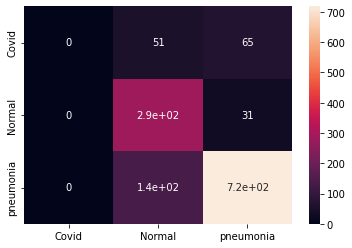

In [10]:
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

## Plotting Results

In [11]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Rounds")
    plt.ylabel("Value")
    plt.grid(True)

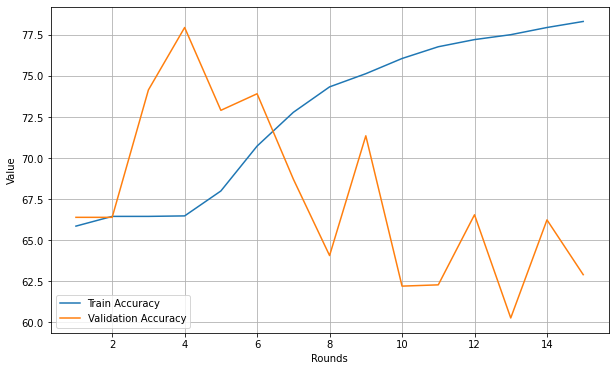

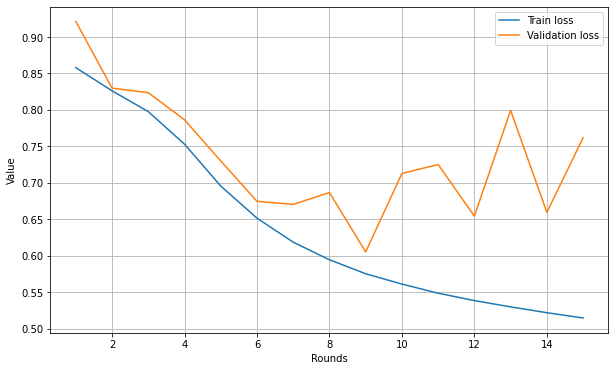

In [12]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc2, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc2, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model25_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss2, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss2, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model25_loss.png")

## Saving Results

In [13]:
# saving metric values to text file

txt_file_path = output_dir / (experiment_name + ".txt")
with open(txt_file_path.as_posix(), "w") as handle:
    content = []
    for key, val in metric_collection.items():
        line_content = key
        val = [str(k) for k in val]
        line_content = line_content + " " + " ".join(val)
        content.append(line_content)
    handle.write("\n".join(content))

# Model 2

In [14]:
np.random.seed(99)
def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
#         Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')

    ])
    return model


method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc1 = []
tff_val_acc1 = []
tff_train_loss1 = []
tff_val_loss1 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc1.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc1.append(ev_result1[1]*100)
    tff_train_loss1.append(float(tff_metrics.loss))
    tff_val_loss1.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model15.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc1,
                     "val_sparse_categorical_accuracy": tff_val_acc1,
                     "loss": tff_train_loss1,
                     "val_loss": tff_val_loss1}

#if eval_model:
#    eval_model.save(model_dir / (experiment_name + ".h5"))
#else:
#    print("training didn't started")
#    exit()



( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,64],float32[64],float32[256,128],float32[128],float32[128,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,64],float32[64],float32[256,128],float32[128],float32[128,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6618871688842773,loss=0.8733580708503723,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.9139747752906373 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6631712317466736,loss=0.8458589315414429,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.8312667400940604 and Validation accuracy : 66.38198494911194
round  3, metrics=<sparse_categorical_accuracy=0.6640856266021729,loss=0.8280559182167053,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.835135

# Evaluation

In [15]:
eval_model1.load_weights('./checkpoints/my_checkpoint')

In [16]:
loaded_model = tf.keras.models.load_model('federated_best_model15.h5')

In [17]:
pred2 = loaded_model.predict(X_test)

In [18]:
pred2 = np.argmax(pred2, axis=-1)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.60      0.88      0.71       317
           2       0.88      0.85      0.87       855

    accuracy                           0.78      1288
   macro avg       0.49      0.58      0.53      1288
weighted avg       0.73      0.78      0.75      1288



c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ushou\downloads\data science and ai\msc project\federated\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

<AxesSubplot:>

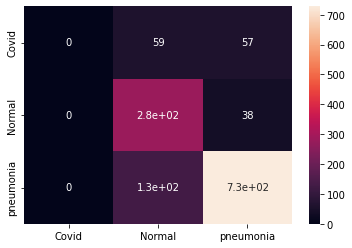

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

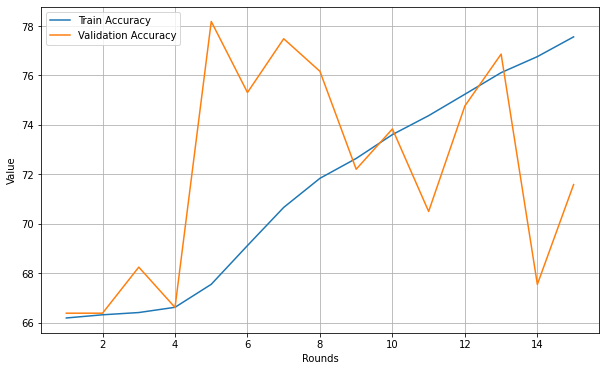

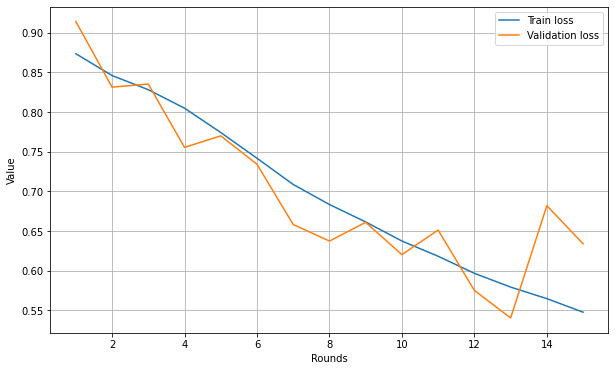

In [21]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc1, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc1, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model15_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss1, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss1, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model15_loss.png")

# Model 3

In [22]:
np.random.seed(99)

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')

    ])
    return model



method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc3 = []
tff_val_acc3 = []
tff_train_loss3 = []
tff_val_loss3 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc3.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc3.append(ev_result1[1]*100)
    tff_train_loss3.append(float(tff_metrics.loss))
    tff_val_loss3.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model35.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc3,
                     "val_sparse_categorical_accuracy": tff_val_acc3,
                     "loss": tff_train_loss3,
                     "val_loss": tff_val_loss3}




( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[7200,64],float32[64],float32[64,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[7200,64],float32[64],float32[64,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6624902486801147,loss=0.8420543670654297,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.7939644622506562 and Validation accuracy : 66.38198494911194
round  2, metrics=<sparse_categorical_accuracy=0.6679961085319519,loss=0.7626878619194031,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.7448211093867048 and Validation accuracy : 71.5062141418457
round  3, metrics=<sparse_categorical_accuracy=0.6871401071548462,loss=0.714186429977417,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.678681398770824 and Validation accuracy : 81.13353848457336
round  4, metrics=<sparse_categorical_accuracy=0.7046887278556824,loss=0.676

# Evaluation

In [23]:
model3 = tf.keras.models.load_model('federated_best_model35.h5')

In [24]:
pred3 = model3.predict(X_test)

In [25]:
pred3 = np.argmax(pred3, axis=-1)

In [26]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       0.94      0.73      0.83       116
           1       0.82      0.61      0.70       317
           2       0.85      0.96      0.90       855

    accuracy                           0.85      1288
   macro avg       0.87      0.77      0.81      1288
weighted avg       0.85      0.85      0.84      1288



<AxesSubplot:>

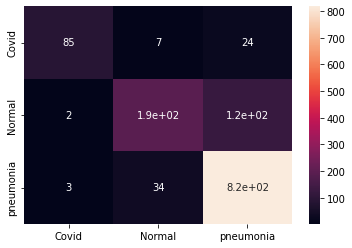

In [27]:
cm = confusion_matrix(y_test, pred3)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

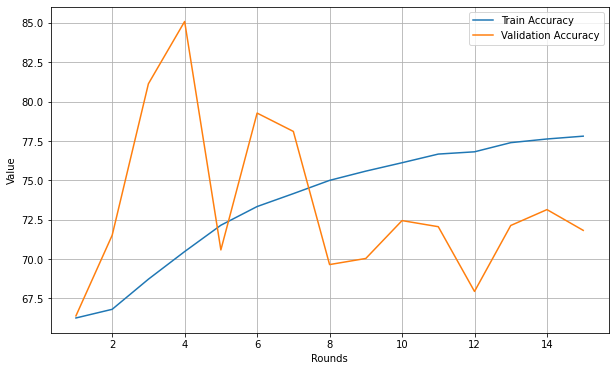

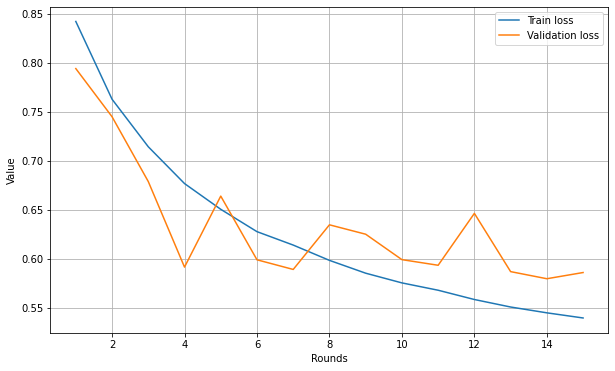

In [28]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc3, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc3, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model35_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss3, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss3, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model35_loss.png")

# Model 4

In [29]:
np.random.seed(99)

def model1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
#         Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')

    ])
    return model



method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 15


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc4 = []
tff_val_acc4 = []
tff_train_loss4 = []
tff_val_loss4 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]*100}")
    tff_train_acc4.append(float(tff_metrics.sparse_categorical_accuracy)*100)
    tff_val_acc4.append(ev_result1[1]*100)
    tff_train_loss4.append(float(tff_metrics.loss))
    tff_val_loss4.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_model45.h5")
        

metric_collection = {"sparse_categorical_accuracy": tff_train_acc4,
                     "val_sparse_categorical_accuracy": tff_val_acc4,
                     "loss": tff_train_loss4,
                     "val_loss": tff_val_loss4}


( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,512],float32[512],float32[512,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,512],float32[512],float32[512,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.6637938022613525,loss=0.8150493502616882,keras_training_time_client_sum_sec=0.0>
Validation loss : 1.2273611030223206 and Validation accuracy : 25.38819909095764
round  2, metrics=<sparse_categorical_accuracy=0.7033852338790894,loss=0.6791269183158875,keras_training_time_client_sum_sec=0.0>
Validation loss : 2.994805367096611 and Validation accuracy : 9.627329558134079
round  3, metrics=<sparse_categorical_accuracy=0.7271984219551086,loss=0.6356685757637024,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.9860024792807442 and Validation accuracy : 73.75776171684265
round 

# Evaluation

In [30]:
model4 = tf.keras.models.load_model('federated_best_model45.h5')

In [31]:
pred4 = model4.predict(X_test)

In [32]:
pred4 = np.argmax(pred4, axis=-1)

In [33]:
print(classification_report(y_test, pred4))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75       116
           1       0.69      0.91      0.78       317
           2       0.94      0.88      0.91       855

    accuracy                           0.86      1288
   macro avg       0.87      0.80      0.81      1288
weighted avg       0.88      0.86      0.86      1288



<AxesSubplot:>

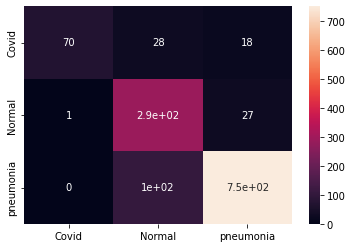

In [34]:
cm = confusion_matrix(y_test, pred4)
sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])

# Plotting Results

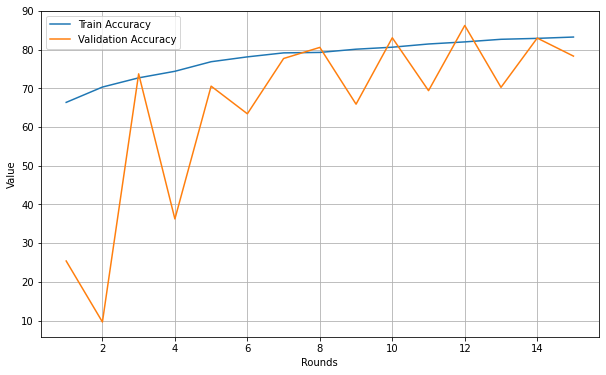

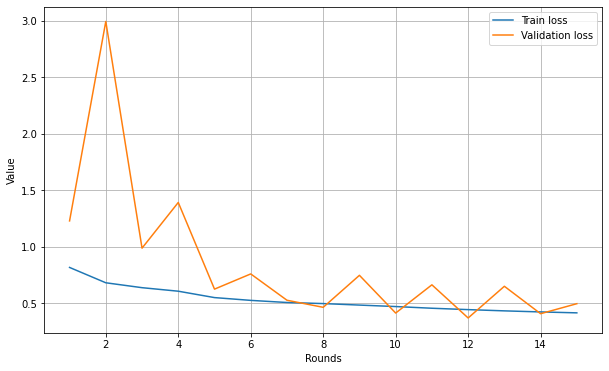

In [35]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc4, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc4, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model45_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss4, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss4, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model45_loss.png")